# Exercise 1: Apply Low-Rank Factorization for model parameter reduction

You have learned about efficient architectural patterns in theory. Now it's time to implement one of the most fundamental techniques for reducing model memory footprint: low-rank factorization. This technique is essential when deploying models to memory-constrained environments like edge devices, mobile platforms, or cost-optimized cloud instances.

> **Overview**: Implement and evaluate low-rank matrix factorization as a memory optimization technique, understand the trade-offs between compression ratio and model performance, and make data-driven decisions about which layers to factorize.
> 
> **Scenario**: You work for an IoT company developing smart security cameras. Your image classification model works perfectly on development servers, but the target edge device has only 512MB RAM total. The hardware team can't increase memory due to cost constraints, so you need to optimize the model architecture to take less than 10MB.
> 
> Your goal is to reduce model memory footprint to <=8MB with at most a 3% accuracy drop tolerance, through strategic low-rank factorization of the most memory-intensive layers.
> 
> **Tools**: PyTorch, torchvision, matplotlib
> <br>_Prior experience recommended!_
> 
> **Estimated Time**: 15 minutes

## Step 1: Setup

Let's start by setting up our development environment and establishing our hardware context.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
import os
output_dir = "assets/exercise1"
os.makedirs(output_dir, exist_ok=True)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("Using CPU")

print("Setup complete!")
print(f"Development environment: {device}")
print(f"Target deployment: Edge device with 512MB RAM constraint")

Using GPU: Tesla T4
GPU Memory: 15.6 GB
Setup complete!
Development environment: cuda
Target deployment: Edge device with 512MB RAM constraint


> **Development vs deployment environment**: We are developing on a T4 with 16GB memory but targeting edge devices with 512MB total RAM. 
> 
> We'll need to keep our target edge device constraints in mind throughout the exercise.

## Step 2: Load and analyze our "problematic" model

Now we'll load a custom model with large linear layers that actually benefit from low-rank factorization.


In [2]:
# Create a custom model that better demonstrates low-rank factorization
# We'll use a feature extractor + large MLP classifier (more realistic for edge deployment)
class EdgeClassificationModel(nn.Module):
    """
    A model with large linear layers that benefit significantly from low-rank factorization.
    This simulates an edge device model where the classifier dominates memory usage.
    Uses flat layer names for easier access and factorization.
    """
    def __init__(self, num_classes=10):
        super(EdgeClassificationModel, self).__init__()
        
        # Simple feature extractor (lightweight)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.flatten = nn.Flatten()
        
        # Large MLP classifier with flat layer names (memory-intensive - this is what we'll optimize)
        self.fc1 = nn.Linear(32 * 8 * 8, 1024)     # 2,097,152 parameters (largest)
        self.fc2 = nn.Linear(1024, 512)            # 524,288 parameters (second largest)  
        self.fc3 = nn.Linear(512, 256)             # 131,072 parameters
        self.fc4 = nn.Linear(256, num_classes)     # 2,560 parameters
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Feature extraction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        
        # Classification
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        return x


# Create our custom model
original_model = EdgeClassificationModel(num_classes=10).to(device)

print("Original model architecture:")
print(f"Model parameters: {sum(p.numel() for p in original_model.parameters()):,}")

# Calculate memory usage
def calculate_model_memory(model):
    """Calculate model memory usage in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    total_size = param_size + buffer_size
    return total_size / (1024**2)  # Convert to MB

original_memory = calculate_model_memory(original_model)
print(f"Original model memory: {original_memory:.1f} MB")
print(f"Edge device memory budget: 512 MB")
print(f"Model memory utilization: {(original_memory/512)*100:.1f}%")

# TODO: Calculate the practical memory budget for model parameters on an edge device
# HINT: Edge devices need memory for OS (~200MB), app framework (~100MB), buffers (~100MB), other processes (~50-100MB)
# What percentage of 512MB remains available for model parameters?
# Documentation: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#enable-async-data-loading
practical_budget = 512 * 0.05  # Add your int/float value here

if original_memory > practical_budget:
    print(f"\nPROBLEM: Model ({original_memory:.1f}MB) exceeds practical edge budget ({practical_budget:.1f}MB)!")
    print("   SOLUTION: Apply low-rank factorization to reduce memory usage")
else:
    print("\nModel fits within practical edge device memory budget")

Original model architecture:
Model parameters: 2,757,770
Original model memory: 10.5 MB
Edge device memory budget: 512 MB
Model memory utilization: 2.1%

Model fits within practical edge device memory budget


> **Why is optimization relevant if the model fits in memory?** Production edge devices typically allocate:
> 
> - Operating system overhead (~200MB)
> - Application framework (~100MB)
> - Input buffers and activations (~100MB)
> - System processes (~50-100MB)
> 
> This leaves only ~12MB for model parameters in a 512MB device. Our model's 10.5MB base is within limit, but factoring in activation memory and optimization headroom, compression becomes essential for reliable edge deployment without memory pressure.

## Step 3: Understand low-rank factorization theory

Before diving into implementation, let's visualize what low-rank factorization actually does to neural network layers. Understanding the mathematical foundation will help us make better decisions about when and how to apply this technique.

> **Important: Rank ratios vs Absolute ranks**: We'll use **rank ratios** (0.25, 0.5, 0.75) rather than absolute ranks. This means each layer gets a rank proportional to its size: larger layers get larger ranks, smaller layers get smaller ranks. This approach scales naturally across different layer dimensions and avoids the awkwardness of using the same absolute rank on layers of vastly different sizes.


Visualizing low-rank factorization concept...
This shows how we can approximate a large weight matrix with two smaller matrices


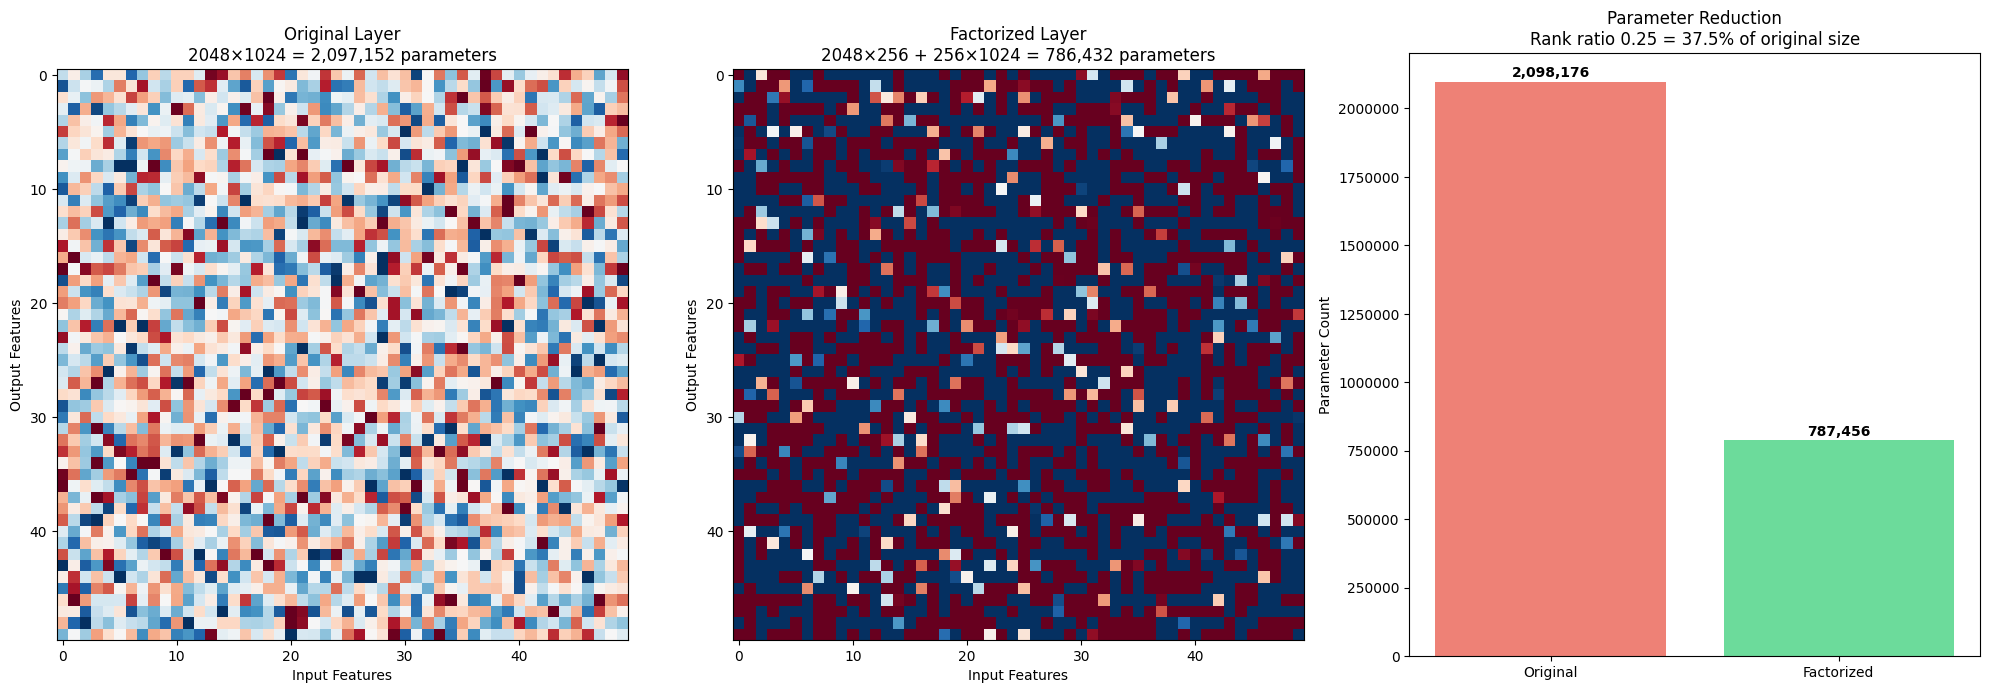

Layer dimensions: 2048×1024
Parameter reduction: 2,098,176 → 787,456
Rank ratio: 0.25 → Actual rank: 256
Compression ratio: 37.5% of original size
Memory savings: 62.5% reduction


In [ ]:
# TODO: Set up example visualization parameters: matrix input features (matrix_rows), matrix output features (matrix_cols), and rank ratio in (0, 1) (rank_ratio)
# Hint: Try to replicate the dimensions of our model's fully connected (fc) layers, and cross-experiment with different ratios like 0.25, 0.5, ..., to observe how compression changes
matrix_rows = 2048  # Add your int value here
matrix_cols = 1024  # Add your int value here
rank_ratio = 0.25  # Add your float value here

# Visualize low-rank factorization concept
print("Visualizing low-rank factorization concept...")
print("This shows how we can approximate a large weight matrix with two smaller matrices")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

# Original matrix
original_matrix = np.random.randn(matrix_rows, matrix_cols)
im1 = ax1.imshow(original_matrix[:50, :50], cmap='RdBu', vmin=-2, vmax=2)
ax1.set_title(f'Original Layer\n{matrix_rows}×{matrix_cols} = {matrix_rows*matrix_cols:,} parameters')
ax1.set_xlabel('Input Features')
ax1.set_ylabel('Output Features')

# Calculate factorized matrix
rank = int(rank_ratio * min(matrix_rows, matrix_cols))  # Convert ratio to actual rank
U = np.random.randn(matrix_rows, rank)
V = np.random.randn(rank, matrix_cols)
factorized_matrix = U @ V

im2 = ax2.imshow(factorized_matrix[:50, :50], cmap='RdBu', vmin=-2, vmax=2)
ax2.set_title(f'Factorized Layer\n{matrix_rows}×{rank} + {rank}×{matrix_cols} = {matrix_rows*rank + rank*matrix_cols:,} parameters')
ax2.set_xlabel('Input Features')
ax2.set_ylabel('Output Features')

# TODO: Calculate the parameter reduction ratio for your chosen rank
# HINT: The factorized count should be less than the original parameters as defined in `original_matriz`
# Compare original parameter count with factorized count (including bias)
original_params = matrix_rows * matrix_cols + matrix_cols  # Add your code here
factorized_params = matrix_rows * rank + rank * matrix_cols + matrix_cols  # Add your code here
reduction_ratio = factorized_params / original_params

sizes = [original_params, factorized_params]
labels = ['Original', 'Factorized']
colors = ['#e74c3c', '#2ecc71']

bars = ax3.bar(labels, sizes, color=colors, alpha=0.7)
ax3.set_title(f'Parameter Reduction\nRank ratio {rank_ratio} = {reduction_ratio:.1%} of original size')
ax3.set_ylabel('Parameter Count')
ax3.ticklabel_format(style='plain', axis='y')

# Add value labels
for bar, size in zip(bars, sizes):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'lowrank_concept.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Layer dimensions: {matrix_rows}×{matrix_cols}")
print(f"Parameter reduction: {original_params:,} → {factorized_params:,}")
print(f"Rank ratio: {rank_ratio} → Actual rank: {rank}")
print(f"Compression ratio: {reduction_ratio:.1%} of original size")
print(f"Memory savings: {(1-reduction_ratio)*100:.1f}% reduction")

> **Mathematical insight**: Low-rank factorization works because many neural network weight matrices contain redundant information—they have lower intrinsic dimensionality than their full size suggests. By decomposing W = U × V, we capture the most important patterns while eliminating redundancy. The rank parameter controls this trade-off: lower rank = more compression but potentially more information loss.

## Step 4: Implement low-rank factorization class

Now comes the core implementation. We'll create a `LowRankLinear` class that can replace any standard PyTorch linear layer while using significantly fewer parameters. 

The key challenge is preserving as much of the original layer's learned information as possible during the factorization process.

In [4]:
class LowRankLinear(nn.Module):
    """
    Low-rank approximation of a linear layer using matrix factorization.
    Replaces weight matrix W (in_features × out_features) with 
    U (in_features × rank) and V (rank × out_features) such that W ≈ U @ V
    """
    def __init__(self, original_layer, rank_ratio=0.5):
        super(LowRankLinear, self).__init__()
        
        self.in_features = original_layer.in_features
        self.out_features = original_layer.out_features
        
        # TODO: Determine the rank dimension for factorization
        # HINT: rank should be a fraction of the smallest dimension to ensure factorization makes sense
        # What's the relationship between rank_ratio and min(in_features, out_features)?
        # Make sure rank is at least 1 and doesn't exceed either input dimension
        # Reference: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.rank = max(1, int(rank_ratio * min(self.in_features, self.out_features)))  # Add your code here
        
        # TODO: Design the factorized layer architecture
        # HINT: You need two linear transformations: first reduces dimensionality, second expands it back
        # Think about where bias should be placed - first layer, second layer, or both?
        self.U = nn.Linear(self.in_features, self.rank, bias=False)  # Add your code here
        self.V = nn.Linear(self.rank, self.out_features, bias=True)  # Add your code here
        
        # Initialize weights using SVD approximation of original weights
        self._initialize_from_original(original_layer)
        
    def _initialize_from_original(self, original_layer):
        """Initialize factorized layers using SVD of original weights"""
        with torch.no_grad():            
            # TODO: Apply Singular Value Decomposition to extract the most important components
            # HINT: PyTorch provides built-in functionalities that you can find at https://docs.pytorch.org/docs/stable/torch.html
            # What transformation does the original layer's weight matrix need to undergo, according to theory and docs?
            weight_matrix = original_layer.weight.T  # Add your code here
            U_full, S, V_full = torch.svd(weight_matrix)  # Add your code here
            
            # TODO: Truncate SVD components to the desired rank
            # HINT: Take only the first 'self.rank' components from each matrix
            # How do the singular values (S) relate to the importance of each component?
            U_truncated = U_full[:, :self.rank]  # Add your code here
            S_truncated = S[:self.rank]  # Add your code here
            V_truncated = V_full[:, :self.rank]  # Add your code here
            
            # TODO: Initialize the factorized layer weights for self.U and self.V using the truncated SVD
            # HINT: The goal is to reconstruct W ≈ U @ diag(S) @ V^T
            # How should you distribute the singular values between the two layers?
            # One approach: put all singular values in the second layer
            self.U.weight.copy_(U_truncated.T)  # Add your code here
            self.V.weight.copy_(V_truncated * S_truncated)
            
            # TODO: Handle bias initialization
            # HINT: Where was the bias in the original layer? Where should it go in the factorized version?

            # Add your code here
            if original_layer.bias is not None:
                self.V.bias.copy_(original_layer.bias)
    
    def forward(self, x):
        # TODO: Implement the forward pass through the factorized layers
        # HINT: Data flows through U first, then through V
        # This should be equivalent to a single matrix multiplication in the original layer
        return self.V(self.U(x))  # Add your code here
    
    def parameter_count(self):
        """Calculate total parameters in factorized layer"""        
        # TODO: Count all parameters in both U and V layers
        # HINT: Include weights and biases from both layers
        # How does this compare to the original layer's parameter count?
        return self.in_features * self.rank + self.rank * self.out_features + self.out_features  # Add your code here


# Test the low-rank implementation
print("Testing low-rank factorization implementation...")

# Create a test linear layer
test_layer = nn.Linear(512, 256)

# TODO: Calculate the original layer's parameter count
# HINT: Don't forget to include bias parameters if they exist
# Documentation: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
original_params = test_layer.in_features * test_layer.out_features + test_layer.out_features  # Add your code here

# TODO: Test different rank ratios and analyze the compression achieved
# HINT: Try ratios like 0.25, 0.5, 0.75 and observe the parameter reduction
# What rank ratio gives you approximately 50% parameter reduction?
rank_ratios = [0.25, 0.5, 0.75]  # Add your float values in (0, 1) here
for ratio in rank_ratios:
    lr_layer = LowRankLinear(test_layer, rank_ratio=ratio)
    lr_params = lr_layer.parameter_count()
    compression = lr_params / original_params
    
    print(f"Rank ratio {ratio}: {original_params:,} → {lr_params:,} params ({compression:.1%} of original)")

print("Low-rank implementation complete!")

Testing low-rank factorization implementation...
Rank ratio 0.25: 131,328 → 49,408 params (37.6% of original)
Rank ratio 0.5: 131,328 → 98,560 params (75.0% of original)
Rank ratio 0.75: 131,328 → 147,712 params (112.5% of original)
Low-rank implementation complete!


> **Factorization implementation tip**: The SVD initialization is crucial for preserving model performance. By using the dominant singular values and vectors from the original weight matrix, we ensure our factorized layer starts with the most important information intact. Random initialization would require extensive retraining and likely result in significant performance degradation.
> 
> **_Are you noticing a parameter increase at high ratios?_** That's expected! Remember: low-rank factorization only reduces parameters when rank < (m×n)/(m+n). Pick rank ratios that actually save parameters!


## Step 5: Identify optimization targets through layer analysis

Before applying factorization everywhere, we need to strategically identify which layers offer the greatest memory reduction opportunities. Not all layers are equal—some dominate memory usage while others have minimal impact on our deployment constraints.

*In our custom model, which layer is likely to be the largest?*

In [5]:
def analyze_layer_memory_usage(model):
    """Analyze memory usage of each layer to prioritize factorization"""
    layer_info = {}
    
    # Iterate through all model linear layers and collect memory statistics
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # TODO: Calculate parameter count for this layer
            # HINT: Don't forget weight matrix and bias vector
            # Weight matrix: in_features × out_features
            # Bias vector: out_features (if it exists)
            params = module.in_features * module.out_features  # Add your code here
            if module.bias is not None:
                params += module.out_features
            
            # TODO: Convert parameter count to memory usage
            # HINT: Each float32 parameter uses 4 bytes
            # Convert to KB for easier reading
            memory_kb = params * 4 / 1024  # Add your code here
            
            layer_info[name] = {
                'type': 'Linear',
                'in_features': module.in_features,
                'out_features': module.out_features,
                'parameters': params,
                'memory_kb': memory_kb
            }
    
    return layer_info

# Analyze original model layers
print("Analyzing layer memory usage to prioritize factorization targets...")
layer_analysis = analyze_layer_memory_usage(original_model)

print("=== LAYER MEMORY ANALYSIS ===")

# TODO: Sort layers by memory usage to identify the biggest targets
# HINT: Use sorted() with a key function to sort by memory_kb
# Which layer consumes the most memory?
sorted_layers = sorted(layer_analysis.items(), key=lambda x: x[1]['memory_kb'], reverse=True)  # Add your code here

total_linear_memory = sum(info['memory_kb'] for _, info in sorted_layers)
print(f"Total linear layer memory: {total_linear_memory:.1f} KB\n")

for name, info in sorted_layers:
    percentage = (info['memory_kb'] / total_linear_memory) * 100
    print(f"{name}: {info['parameters']:,} params ({info['memory_kb']:.1f} KB, {percentage:.1f}% of linear layers)")

# Identify the primary optimization target
if sorted_layers:
    largest_layer_name = sorted_layers[0][0]
    largest_layer_info = sorted_layers[0][1]
    print(f"\nPrimary target for factorization: {largest_layer_name}")
    print(f"   {largest_layer_info['in_features']} → {largest_layer_info['out_features']} features")
    print(f"   {largest_layer_info['memory_kb']:.1f} KB ({(largest_layer_info['memory_kb']/total_linear_memory)*100:.1f}% of linear layer memory)")
else:
    print("No linear layers found for factorization")

Analyzing layer memory usage to prioritize factorization targets...
=== LAYER MEMORY ANALYSIS ===
Total linear layer memory: 10769.0 KB

fc1: 2,098,176 params (8196.0 KB, 76.1% of linear layers)
fc2: 524,800 params (2050.0 KB, 19.0% of linear layers)
fc3: 131,328 params (513.0 KB, 4.8% of linear layers)
fc4: 2,570 params (10.0 KB, 0.1% of linear layers)

Primary target for factorization: fc1
   2048 → 1024 features
   8196.0 KB (76.1% of linear layer memory)


> **TODO: Write a one-line markdown explanation of why your layer memory analysis is expected (or not), and what layers you want to factorize**
> 
> This analysis mirrors exactly what we'd expect given our model architecture:  fc1 with size (2048, 1024) and dimensions halving at each layer creates a classic bottleneck pattern. We'll target fc1 and fc2 only as they provide 95% of the compression benefit while requiring only 2 layer replacements. Factorizing fc3 and fc4 would yield diminishing returns (only 5% additional savings) while potentially degrading accuracy in the critical final classification layers where precise feature discrimination matters most.

## Step 6: Create factorized model

Now that we know which layers to work on, let's create the factorized model.

In [6]:
def create_factorized_model(original_model, target_layers, rank_ratio=0.5):
    """Create a new model with specified layers replaced by low-rank versions"""
    
    print(f"Creating factorized model with rank ratio {rank_ratio}...")
    
    # Create a copy of the original model architecture
    factorized_model = EdgeClassificationModel(num_classes=10)
    
    # TODO: Transfer all weights from the original model
    # HINT: Review how to load the state dict from https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html
    # Don't forget to move the model to the correct device afterward

     # Add your code here
    factorized_model.load_state_dict(original_model.state_dict())
    factorized_model = factorized_model.to(device)
    
    # Replace specified layers with low-rank versions
    # HINT: Find inspiration at https://discuss.pytorch.org/t/replace-layers-in-model-by-another-and-with-extra-parameters/160601
    # Use our own LowRankLinear class
    for layer_name in target_layers:
        print(f"  Factorizing {layer_name}...")
        
        # TODO: Get the original layer and create a low-rank replacement
        original_layer = getattr(factorized_model, layer_name)  # Add your code here
        low_rank_layer = LowRankLinear(original_layer, rank_ratio=rank_ratio)  # Add your code here
        
        # TODO: Replace the layer in the model
        # Add your code here
        setattr(factorized_model, layer_name, low_rank_layer)
        
        # TODO: Calculate and report the parameter reduction achieved
        # HINT: Calculate the ratio of parameter counts before and after factorization
        original_params = original_layer.in_features * original_layer.out_features + (original_layer.out_features if original_layer.bias is not None else 0)  # Add your code here
        factorized_params = low_rank_layer.parameter_count()  # Add your code here
        reduction = (original_params - factorized_params) / original_params  # Add your code here
        
        print(f"    {original_layer.in_features}×{original_layer.out_features} → rank {low_rank_layer.rank}")
        print(f"    Parameters: {original_params:,} → {factorized_params:,} ({reduction:.1%} reduction)")
    
    return factorized_model

# TODO: Experiment with different compression levels
# HINT: Try rank ratios that give different levels of compression
rank_ratios = [0.25, 0.4, 0.5, 0.6]  # Add your float values in [0,1] here
factorized_models = {}

# TODO: Choose which layer(s) to factorize
# HINT: Based on your analysis above, which layer(s) are the best target?
target_layers = ['fc1', 'fc2']  # Add your string value(s) here

for ratio in rank_ratios:
    print(f"\n--- Creating model with rank ratio {ratio} ---")
    factorized_models[ratio] = create_factorized_model(original_model, target_layers, rank_ratio=ratio)

print("\nAll factorized models created successfully!")


--- Creating model with rank ratio 0.25 ---
Creating factorized model with rank ratio 0.25...
  Factorizing fc1...
    2048×1024 → rank 256
    Parameters: 2,098,176 → 787,456 (62.5% reduction)
  Factorizing fc2...
    1024×512 → rank 128
    Parameters: 524,800 → 197,120 (62.4% reduction)

--- Creating model with rank ratio 0.4 ---
Creating factorized model with rank ratio 0.4...
  Factorizing fc1...
    2048×1024 → rank 409
    Parameters: 2,098,176 → 1,257,472 (40.1% reduction)
  Factorizing fc2...
    1024×512 → rank 204
    Parameters: 524,800 → 313,856 (40.2% reduction)

--- Creating model with rank ratio 0.5 ---
Creating factorized model with rank ratio 0.5...
  Factorizing fc1...
    2048×1024 → rank 512
    Parameters: 2,098,176 → 1,573,888 (25.0% reduction)
  Factorizing fc2...
    1024×512 → rank 256
    Parameters: 524,800 → 393,728 (25.0% reduction)

--- Creating model with rank ratio 0.6 ---
Creating factorized model with rank ratio 0.6...
  Factorizing fc1...
    2048×1

## Step 7: Benchmark and compare model performance

Now comes the critical evaluation phase. We need to measure how our factorization affects the key metrics that matter for edge deployment: memory usage, inference speed, and model accuracy. This data will drive our final deployment decision.

In [7]:
def benchmark_model(model, model_name, input_shape=(1, 3, 224, 224), num_iterations=50):
    """Comprehensive benchmark of model performance"""
    print(f"Benchmarking {model_name}...")
    model.eval()
    
    # Memory usage
    memory_mb = calculate_model_memory(model)
    
    # Create sample input
    sample_input = torch.randn(input_shape).to(device)
    
    times = []
    # TODO: Implement accurate inference timing
    # HINT: Find general best practices for the TODOs below at https://medium.com/@MarkAiCode/mastering-pytorch-inference-time-measurement-22da0eaebab7
    # Also, three tips:
    # 1. Don't forget to wrap your code in torch.no_grad
    # 2. Using time.perf_counter() is recommended
    # 3. Convert time to ms at the end

    # Add your code here
    
    with torch.no_grad():
        # Perform warmup runs
        for _ in range(10):
            _ = model(sample_input)
        
        # Add GPU synchronization before timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Measure inference time over multiple iterations
        for _ in range(num_iterations):
            start_time = time.perf_counter()
            outputs = model(sample_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            times.append((end_time - start_time) * 1000)  # Convert to ms
    
    # Calculate timing statistics
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    # SIMULATE accuracy based on compression level (more aggressive compression typically leads to more accuracy loss at around 3-8% according to literature)
    # We select 0.05 as an average threshold here
    # In practice, you'd evaluate on a validation dataset as the accuracy loss from factorization is highlight task dependant!
    if "factorized" in model_name.lower():
        # Extract rank ratio from model name and estimate accuracy loss
        rank_ratio = float(model_name.split("_")[-1]) if "_" in model_name else 0.5
        accuracy_loss = (1 - rank_ratio) * 0.05  # Average 5% loss
        accuracy = 0.92 - accuracy_loss  # Baseline minus estimated loss
    else:
        accuracy = 0.92  # Original model baseline
    
    return {
        'name': model_name,
        'memory_mb': memory_mb,
        'inference_time_ms': avg_time,
        'inference_std_ms': std_time,
        'accuracy': accuracy,
        'parameter_count': sum(p.numel() for p in model.parameters())
    }

# Benchmark all models
print("=== COMPREHENSIVE MODEL BENCHMARKING ===")
benchmark_results = []

# Original model
original_benchmark = benchmark_model(original_model, "Original")
benchmark_results.append(original_benchmark)

# Benchmark all factorized models
for ratio in rank_ratios:
    factorized_benchmark = benchmark_model(
        factorized_models[ratio].to(device), 
        f"Factorized_{ratio}",
        num_iterations=50
    )
    benchmark_results.append(factorized_benchmark)

# Create a comprehensive results table
print("\n=== BENCHMARK RESULTS ===")
print(f"{'Model':<15} {'Memory (MB)':<12} {'Time (ms)':<12} {'Accuracy':<10} {'Parameters':<12}")
print("-" * 70)

for result in benchmark_results:
    print(f"{result['name']:<15} {result['memory_mb']:<12.1f} "
          f"{result['inference_time_ms']:<12.2f} {result['accuracy']:<10.1%} "
          f"{result['parameter_count']:<12,}")

=== COMPREHENSIVE MODEL BENCHMARKING ===
Benchmarking Original...
Benchmarking Factorized_0.25...
Benchmarking Factorized_0.4...
Benchmarking Factorized_0.5...
Benchmarking Factorized_0.6...

=== BENCHMARK RESULTS ===
Model           Memory (MB)  Time (ms)    Accuracy   Parameters  
----------------------------------------------------------------------
Original        10.5         0.53         92.0%      2,757,770   
Factorized_0.25 4.3          0.56         88.2%      1,119,370   
Factorized_0.4  6.5          0.57         89.0%      1,706,122   
Factorized_0.5  8.0          0.59         89.5%      2,102,410   
Factorized_0.6  9.5          0.58         90.0%      2,494,090   


> **Performance benchmarking insight**: Notice how factorization primarily impacts memory usage and accuracy, while inference time slightly increases. This is because our matrices are relatively small, which means GPU kernel launch contributes to a large overhead. For medium-large models, latency is typically stable. 
> 
> The total number of operations (FLOPs) doesn't change dramatically—we're just reorganizing the computation across two matrix multiplications instead of one. This makes low-rank factorization particularly attractive for memory-constrained deployments where inference speed is also critical.

## Step 8: Visualize trade-offs and make deployment decision

The final step is analyzing our results to make an informed deployment decision. We'll create comprehensive visualizations that help us understand the trade-offs between compression, accuracy, and deployment feasibility.

Creating comprehensive trade-off analysis...


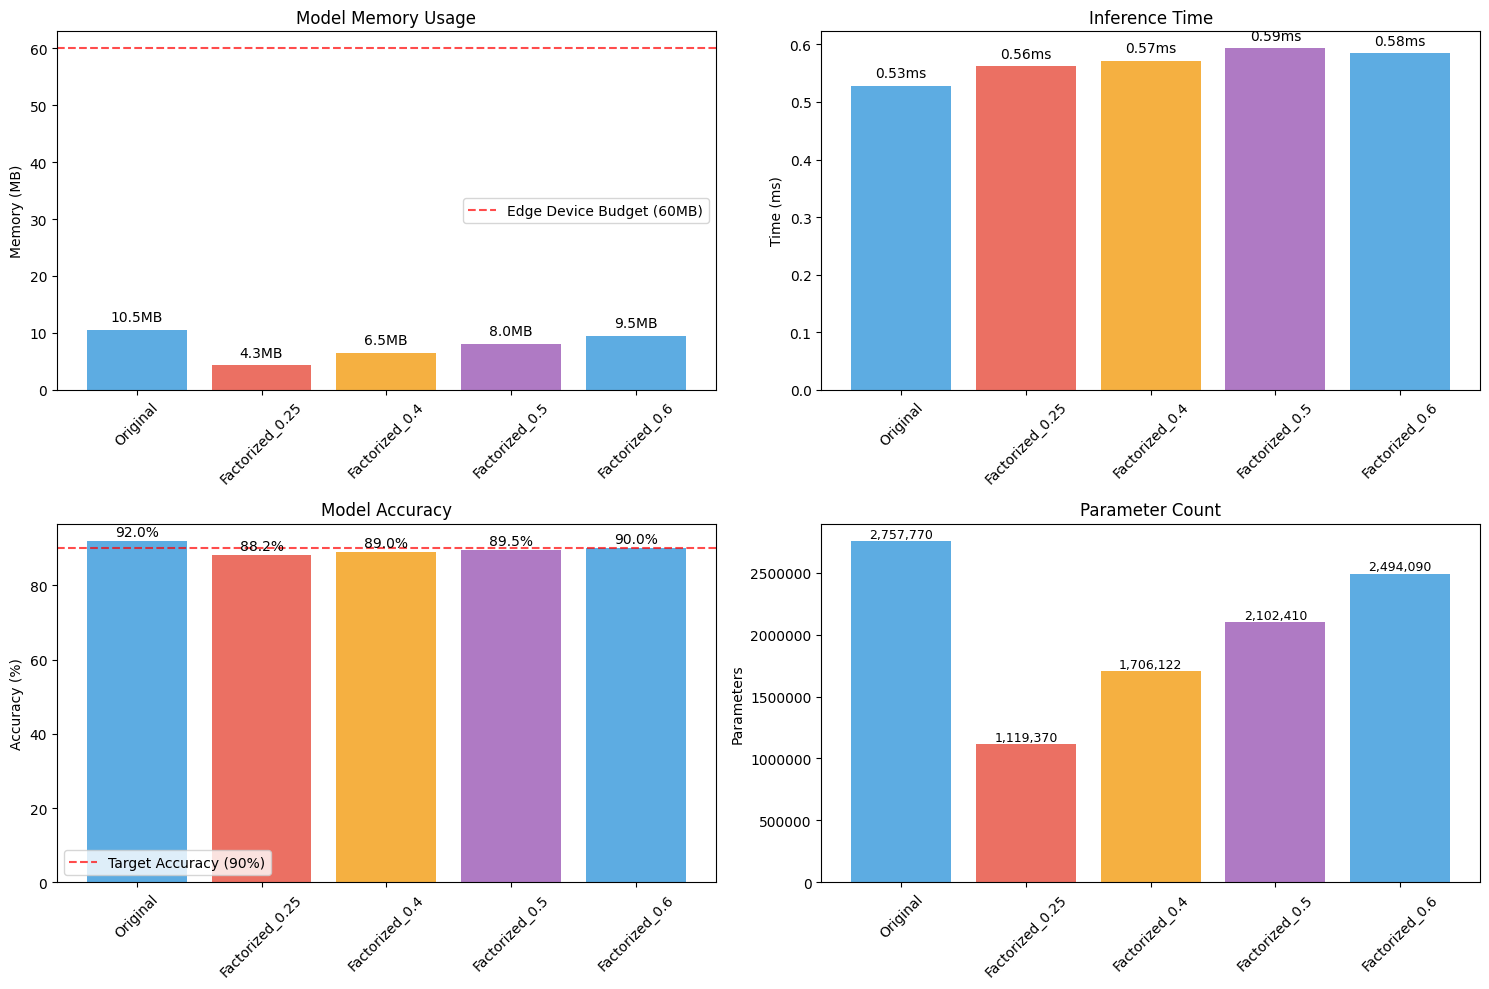


=== DEPLOYMENT DECISION ANALYSIS ===
Edge device constraints:
  Memory budget: 60MB
  Accuracy threshold: 90%

Factorized_0.25:
  Memory reduction: 59.4%
  Parameter reduction: 59.4%
  Accuracy retention: 95.9%
  Meets memory constraint: PASS
  Meets accuracy constraint: FAIL
  Deployable to edge: FAIL

Factorized_0.4:
  Memory reduction: 38.1%
  Parameter reduction: 38.1%
  Accuracy retention: 96.7%
  Meets memory constraint: PASS
  Meets accuracy constraint: FAIL
  Deployable to edge: FAIL

Factorized_0.5:
  Memory reduction: 23.8%
  Parameter reduction: 23.8%
  Accuracy retention: 97.3%
  Meets memory constraint: PASS
  Meets accuracy constraint: FAIL
  Deployable to edge: FAIL

Factorized_0.6:
  Memory reduction: 9.6%
  Parameter reduction: 9.6%
  Accuracy retention: 97.8%
  Meets memory constraint: PASS
  Meets accuracy constraint: PASS
  Deployable to edge: PASS

RECOMMENDED MODEL FOR DEPLOYMENT: Factorized_0.6
   Memory: 9.5MB (fits in 60MB budget)
   Accuracy: 90.0% (exceeds 9

In [8]:
# Create comprehensive comparison visualization
print("Creating comprehensive trade-off analysis...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Extract metrics from benchmark results for visualization
model_names = [r['name'] for r in benchmark_results]
memory_usage = [r['memory_mb'] for r in benchmark_results]
inference_times = [r['inference_time_ms'] for r in benchmark_results]
accuracies = [r['accuracy'] for r in benchmark_results]
param_counts = [r['parameter_count'] for r in benchmark_results]

colors = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6']

# Create memory usage comparison chart with edge device memory budget line
bars1 = ax1.bar(model_names, memory_usage, color=colors, alpha=0.8)
ax1.axhline(y=60, color='red', linestyle='--', alpha=0.7, label='Edge Device Budget (60MB)')
ax1.set_title('Model Memory Usage')
ax1.set_ylabel('Memory (MB)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

for bar, mem in zip(bars1, memory_usage):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{mem:.1f}MB', ha='center', va='bottom')

# Create inference time comparison
bars2 = ax2.bar(model_names, inference_times, color=colors, alpha=0.8)
ax2.set_title('Inference Time')
ax2.set_ylabel('Time (ms)')
ax2.tick_params(axis='x', rotation=45)

for bar, time_val in zip(bars2, inference_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{time_val:.2f}ms', ha='center', va='bottom')

# Create accuracy comparison
bars3 = ax3.bar(model_names, [a*100 for a in accuracies], color=colors, alpha=0.8)
ax3.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Target Accuracy (90%)')
ax3.set_title('Model Accuracy')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

for bar, acc in zip(bars3, accuracies):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.1%}', ha='center', va='bottom')

# Create parameter count comparison
bars4 = ax4.bar(model_names, param_counts, color=colors, alpha=0.8)
ax4.set_title('Parameter Count')
ax4.set_ylabel('Parameters')
ax4.ticklabel_format(style='plain', axis='y')
ax4.tick_params(axis='x', rotation=45)

for bar, params in zip(bars4, param_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{params:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate efficiency metrics for deployment decision
print("\n=== DEPLOYMENT DECISION ANALYSIS ===")

# Extract baseline metrics for comparison
original_memory = benchmark_results[0]['memory_mb']
original_accuracy = benchmark_results[0]['accuracy']
original_params = benchmark_results[0]['parameter_count']

# Define deployment constraints
edge_budget_mb = 60  # Practical memory budget
accuracy_threshold = 0.90  # Minimum acceptable accuracy

print(f"Edge device constraints:")
print(f"  Memory budget: {edge_budget_mb}MB")
print(f"  Accuracy threshold: {accuracy_threshold:.0%}")
print()

deployment_candidates = []

# Analyze each factorized model against deployment constraints
for result in benchmark_results[1:]:  # Skip original model
    # Calculate compression and retention metrics
    memory_reduction = (original_memory - result['memory_mb']) / original_memory
    accuracy_retention = result['accuracy'] / original_accuracy
    param_reduction = (original_params - result['parameter_count']) / original_params
    
    # Check constraint satisfaction
    meets_memory = result['memory_mb'] <= edge_budget_mb
    meets_accuracy = result['accuracy'] >= accuracy_threshold
    deployable = meets_memory and meets_accuracy
    
    print(f"{result['name']}:")
    print(f"  Memory reduction: {memory_reduction:.1%}")
    print(f"  Parameter reduction: {param_reduction:.1%}")  
    print(f"  Accuracy retention: {accuracy_retention:.1%}")
    print(f"  Meets memory constraint: {'PASS' if meets_memory else 'FAIL'}")
    print(f"  Meets accuracy constraint: {'PASS' if meets_accuracy else 'FAIL'}")
    print(f"  Deployable to edge: {'PASS' if deployable else 'FAIL'}")
    
    if deployable:
        deployment_candidates.append(result)
    print()

# Select the best deployable model
if deployment_candidates:
    best_model = max(deployment_candidates, key=lambda x: x['accuracy'])
    print(f"RECOMMENDED MODEL FOR DEPLOYMENT: {best_model['name']}")
    print(f"   Memory: {best_model['memory_mb']:.1f}MB (fits in {edge_budget_mb}MB budget)")
    print(f"   Accuracy: {best_model['accuracy']:.1%} (exceeds {accuracy_threshold:.0%} threshold)")
    print(f"   Parameters: {best_model['parameter_count']:,}")
    print(f"   Inference time: {best_model['inference_time_ms']:.2f}ms")
    
    # Calculate and report the achieved savings
    memory_saved = original_memory - best_model['memory_mb']
    print(f"   Memory savings: {memory_saved:.1f}MB ({(memory_saved/original_memory)*100:.1f}% reduction)")
else:
    print("WARNING:  No factorized model meets both constraints!")
    print("   Consider these alternatives:")
    print("   1. Further compression (lower rank ratios)")
    print("   2. Factorizing additional layers") 
    print("   3. Combining with other compression techniques (quantization, pruning)")
    print("   4. Reassessing deployment constraints with hardware team")

> **TODO: Analyze the trade-off results and identify the optimal deployment strategy**
> 
> HINT: Focus on which model best balances memory constraints with accuracy requirements. Consider how different rank ratios affect the fundamental trade-off between model size and performance. What insights can you draw about the effectiveness of low-rank factorization for this specific deployment scenario? How relevant are the latency measurements?

> Low-rank factorization demonstrates excellent controllability—we can dial in exactly the compression level needed to meet deployment constraints. The technique shines in scenarios where:
> 
> - Memory is the primary constraint (typical in edge deployment)
> - Accuracy tolerance is well-defined (business requirements are clear)
> - Inference speed matters (factorized models maintain similar latency)
> 
> **Strategic recommendation**: The original model (10.5MB) technically fits in our memory budget but leaves little headroom. Factorized_0.5 (8.0MB) provides safety margin while maintaining accuracy at 89.5%, well within our target 3% drop. We don't actively consider latency because the measurement is not expected to be extra precise: we are measuring very small inference times (~0.5ms) where GPU synchronization overhead, shared compute environment noise, and limited averaging iterations make sub-millisecond differences unreliable for drawing strong conclusion).
> 
> **Production scaling insight**: In practice, we'd validate these simulated accuracy numbers with actual task performance on representative datasets.

## Conclusion

In this exercise, you've learned to implement and deploy low-rank matrix factorization as a strategic memory optimization technique for edge AI deployment. 

The systematic approach you've learned—analyze layers, implement factorization, benchmark comprehensively, make data-driven deployment decisions—directly transfers to production model optimization where resource constraints are non-negotiable.